In [2]:
from src.model import VAE
from src.trainer import CDVAETrainer
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [3]:
from corruption_utils import corruptions

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# %%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [6]:
from src.utils import CMNISTGenerator, CMNIST

In [7]:
np.random.seed(101)
torch.manual_seed(101)

In [8]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.15,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.1,
        lambda x: corruptions.scale(x, 5): 0.1,
        corruptions.brightness: 0.2
    },
)
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

In [9]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:14<00:00, 4136.38item/s]


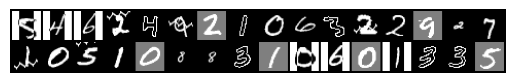

In [10]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [11]:
EPOCHS = 41

### cosine sim + label-flipping

In [11]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 8,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "label_flipping": LABEL_FLIPPING,
    },
    verbose_period=5,
    device=device,
)

In [12]:
trainer.fit(EPOCHS, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 90.83it/s] 


val_recontr_loss=52.801, val_kl_c=14.884, val_kl_s=12.639, val_c_loss=2.305, val_s_loss=0.398
gMIG: -0.018; elbo: -80.324


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 191.18it/s]


val_recontr_loss=24.905, val_kl_c=15.223, val_kl_s=15.191, val_c_loss=2.122, val_s_loss=0.471
gMIG: -0.013; elbo: -55.32


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 254.70it/s]


val_recontr_loss=18.913, val_kl_c=15.594, val_kl_s=15.766, val_c_loss=2.054, val_s_loss=0.496
gMIG: -0.017; elbo: -50.273


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 262.46it/s]


val_recontr_loss=16.355, val_kl_c=15.582, val_kl_s=15.974, val_c_loss=1.994, val_s_loss=0.522
gMIG: -0.015; elbo: -47.911


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 254.57it/s]


val_recontr_loss=15.055, val_kl_c=15.806, val_kl_s=16.719, val_c_loss=2.007, val_s_loss=0.524
gMIG: -0.015; elbo: -47.58


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 249.22it/s]


val_recontr_loss=14.483, val_kl_c=15.947, val_kl_s=16.568, val_c_loss=2.002, val_s_loss=0.537
gMIG: -0.019; elbo: -46.997


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 258.33it/s]


val_recontr_loss=14.271, val_kl_c=15.887, val_kl_s=16.660, val_c_loss=1.952, val_s_loss=0.548
gMIG: -0.017; elbo: -46.818


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 256.88it/s]


val_recontr_loss=13.453, val_kl_c=16.076, val_kl_s=16.972, val_c_loss=1.965, val_s_loss=0.556
gMIG: -0.019; elbo: -46.502


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 246.78it/s]


val_recontr_loss=13.143, val_kl_c=16.508, val_kl_s=17.240, val_c_loss=1.949, val_s_loss=0.559
gMIG: -0.019; elbo: -46.892


In [13]:
trainer.evaluate(test_loader, False, 0)

(0.30414714601679155, -53.5630616014377)

In [13]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 416.93it/s]


In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

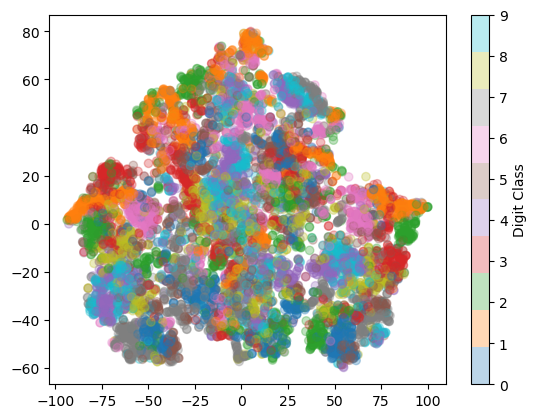

In [15]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

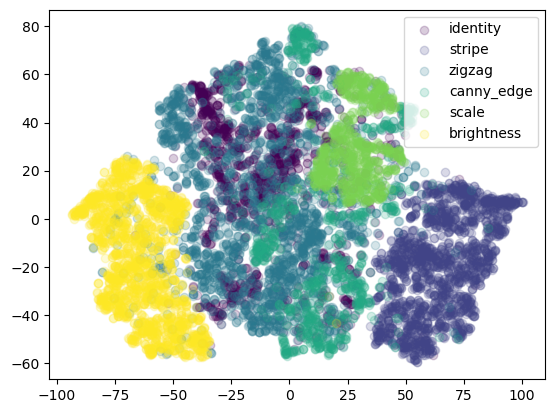

In [16]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [17]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

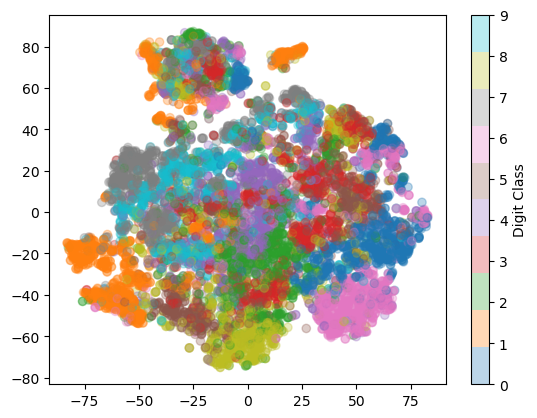

In [18]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

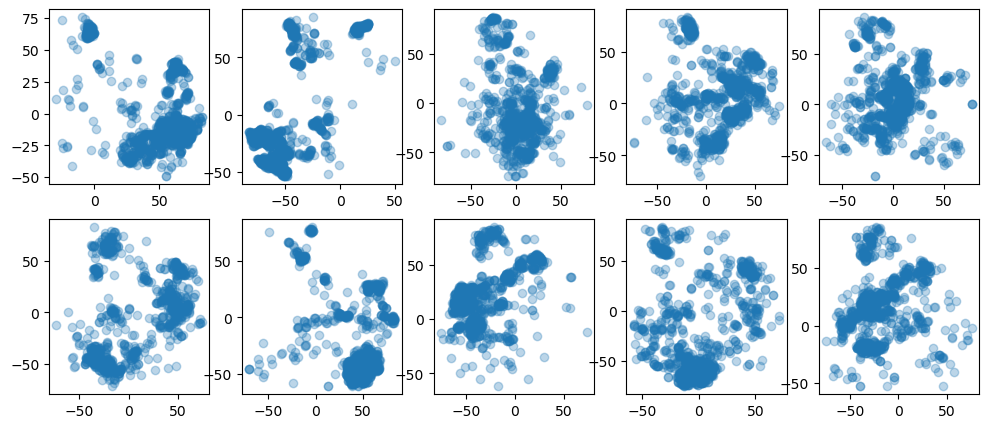

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)
    

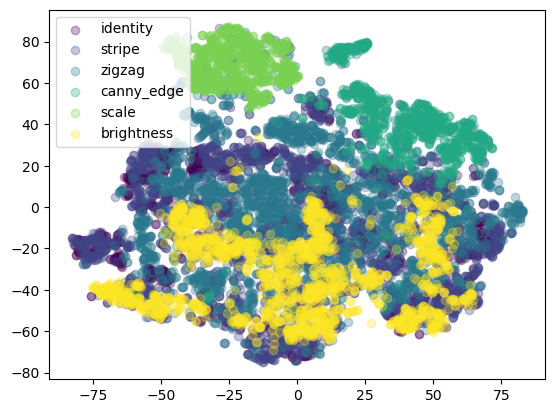

In [20]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

### l2 sim + lable-flipping

In [22]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [100, 100]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="l2",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 8,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "label_flipping": LABEL_FLIPPING,
    },
    verbose_period=5,
    device=device,
)

In [23]:
trainer.fit(EPOCHS, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 259.54it/s]


val_recontr_loss=63.630, val_kl_c=10.268, val_kl_s=10.078, val_c_loss=0.415, val_s_loss=0.117
gMIG: 0.129; elbo: -83.976


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 243.45it/s]


val_recontr_loss=34.526, val_kl_c=15.984, val_kl_s=14.587, val_c_loss=0.202, val_s_loss=0.125
gMIG: 0.243; elbo: -65.097


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 261.25it/s]


val_recontr_loss=28.666, val_kl_c=17.471, val_kl_s=17.078, val_c_loss=0.220, val_s_loss=0.118
gMIG: 0.263; elbo: -63.215


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 264.70it/s]


val_recontr_loss=24.077, val_kl_c=18.305, val_kl_s=19.221, val_c_loss=0.186, val_s_loss=0.117
gMIG: 0.273; elbo: -61.602


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 235.17it/s]


val_recontr_loss=22.696, val_kl_c=18.869, val_kl_s=20.739, val_c_loss=0.168, val_s_loss=0.116
gMIG: 0.288; elbo: -62.304


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 266.76it/s]


val_recontr_loss=21.928, val_kl_c=18.160, val_kl_s=21.573, val_c_loss=0.192, val_s_loss=0.118
gMIG: 0.275; elbo: -61.661


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 262.47it/s]


val_recontr_loss=20.388, val_kl_c=19.057, val_kl_s=21.989, val_c_loss=0.183, val_s_loss=0.116
gMIG: 0.285; elbo: -61.433


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 259.02it/s]


val_recontr_loss=20.203, val_kl_c=18.486, val_kl_s=22.798, val_c_loss=0.181, val_s_loss=0.116
gMIG: 0.281; elbo: -61.488


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 264.21it/s]


val_recontr_loss=18.836, val_kl_c=19.021, val_kl_s=23.371, val_c_loss=0.188, val_s_loss=0.114
gMIG: 0.286; elbo: -61.228


In [24]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 446.60it/s]


In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

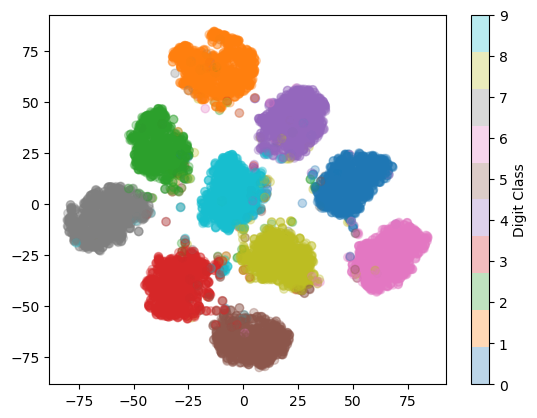

In [26]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

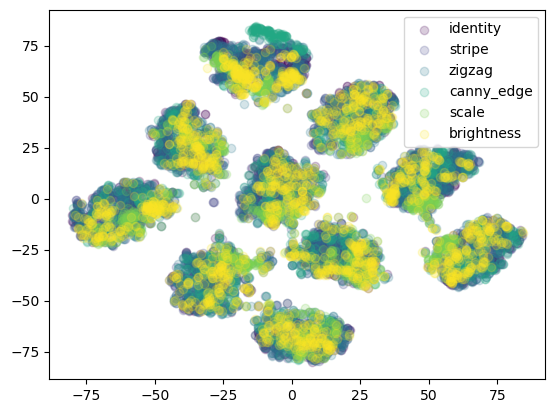

In [27]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [28]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

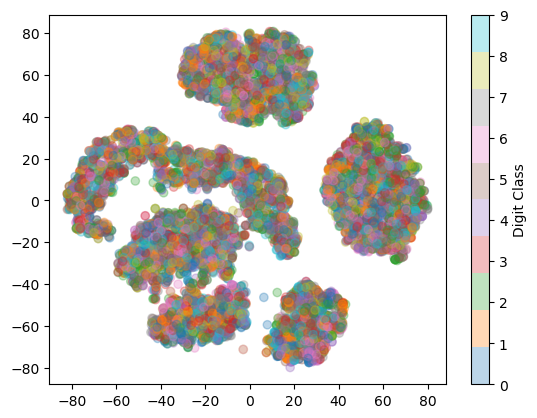

In [29]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

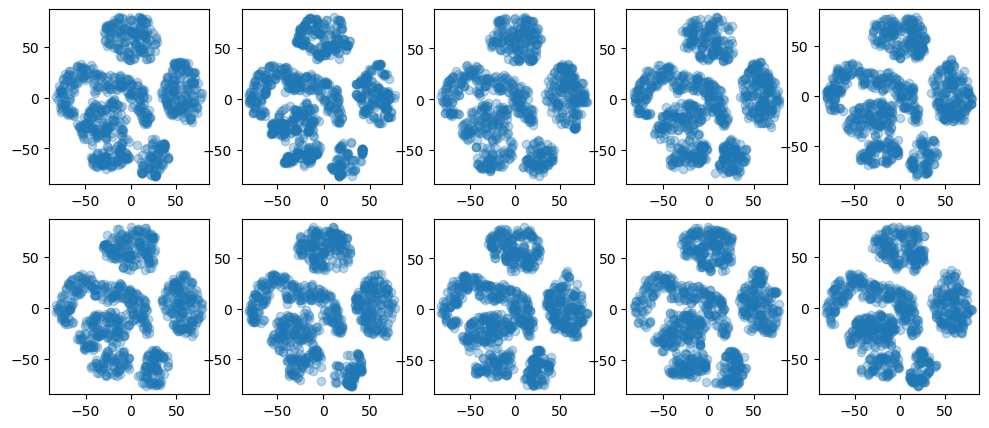

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

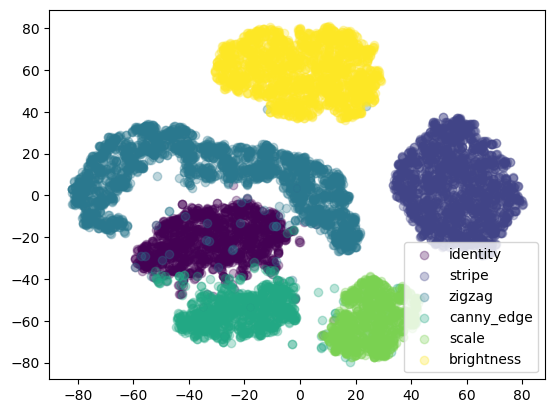

In [31]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

### Jeffrey divergence + label flipping

In [16]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [5, 5]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="jeffrey",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 128,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "label_flipping": LABEL_FLIPPING,
    },
    verbose_period=5,
    device=device,
)

In [17]:
trainer.fit(EPOCHS, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 221.04it/s]


val_recontr_loss=61.262, val_kl_c=3.795, val_kl_s=35.296, val_c_loss=0.603, val_s_loss=0.241
gMIG: 0.088; elbo: -100.352


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 221.91it/s]


val_recontr_loss=35.230, val_kl_c=8.922, val_kl_s=21.456, val_c_loss=0.628, val_s_loss=0.324
gMIG: 0.144; elbo: -65.608


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 194.37it/s]


val_recontr_loss=30.010, val_kl_c=11.200, val_kl_s=18.013, val_c_loss=0.815, val_s_loss=0.370
gMIG: 0.167; elbo: -59.222


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 203.08it/s]


val_recontr_loss=26.765, val_kl_c=12.596, val_kl_s=16.138, val_c_loss=1.199, val_s_loss=0.418
gMIG: 0.193; elbo: -55.499


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 191.53it/s]


val_recontr_loss=25.948, val_kl_c=12.908, val_kl_s=16.591, val_c_loss=1.179, val_s_loss=0.392
gMIG: 0.194; elbo: -55.447


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 229.01it/s]


val_recontr_loss=24.756, val_kl_c=13.099, val_kl_s=15.587, val_c_loss=1.232, val_s_loss=0.444
gMIG: 0.196; elbo: -53.443


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 220.49it/s]


val_recontr_loss=24.086, val_kl_c=12.833, val_kl_s=14.572, val_c_loss=1.165, val_s_loss=0.485
gMIG: 0.202; elbo: -51.491


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 223.17it/s]


val_recontr_loss=23.857, val_kl_c=13.152, val_kl_s=14.309, val_c_loss=1.292, val_s_loss=0.417
gMIG: 0.209; elbo: -51.318


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 192.49it/s]


val_recontr_loss=23.063, val_kl_c=14.017, val_kl_s=14.364, val_c_loss=1.411, val_s_loss=0.464
gMIG: 0.219; elbo: -51.443


100%|██████████| 79/79 [00:00<00:00, 272.41it/s]


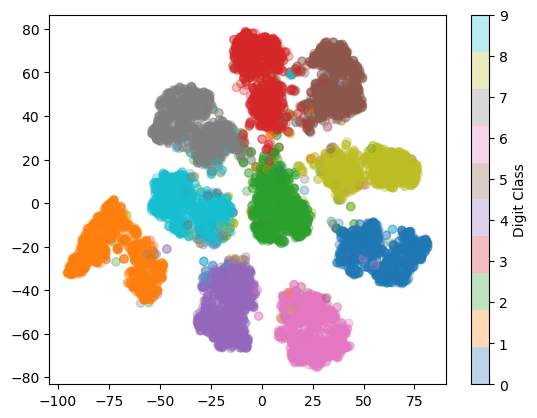

In [18]:
from tqdm import tqdm
from sklearn.manifold import TSNE

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

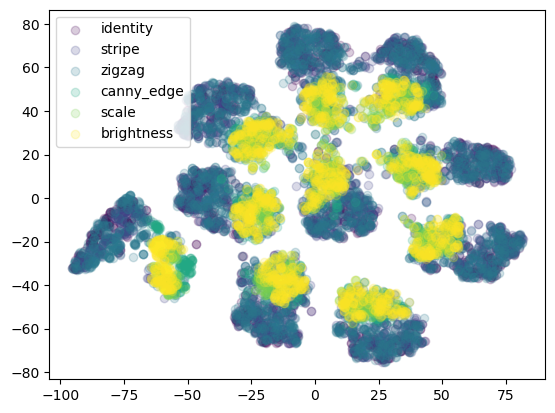

In [19]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

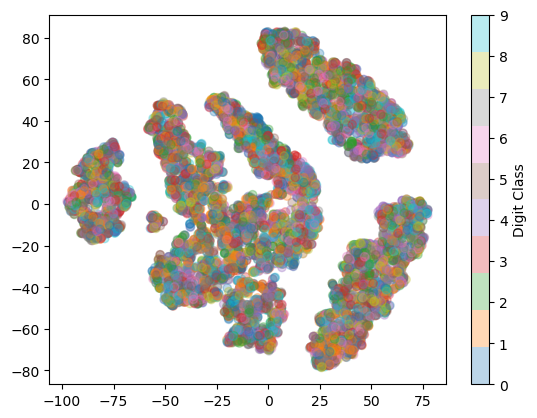

In [20]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

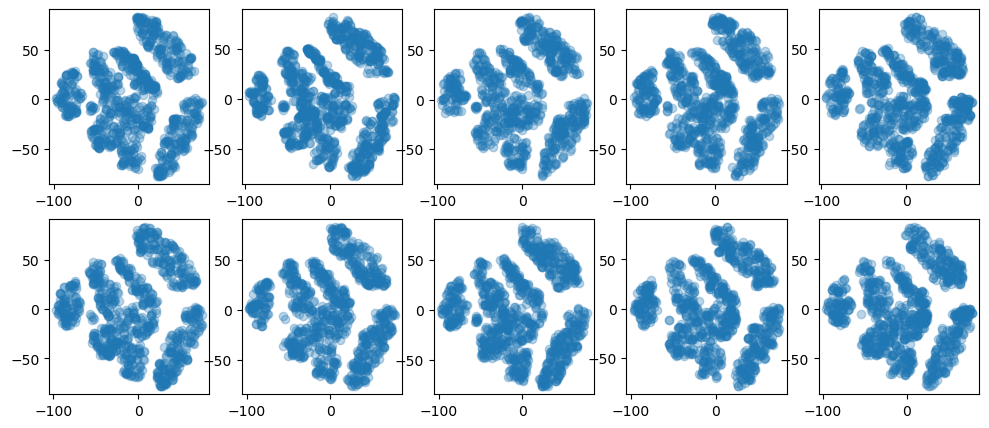

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

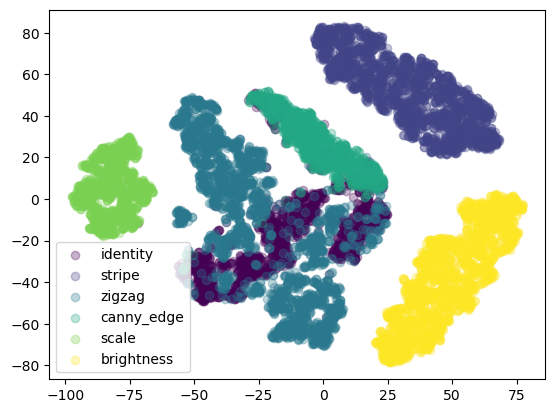

In [22]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

### mahalanobis + label flipping

In [39]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [5, 5]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="mahalanobis",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 128,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "label_flipping": LABEL_FLIPPING,
    },
    verbose_period=5,
    device=device,
)

In [40]:
trainer.fit(EPOCHS, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 252.15it/s]


val_recontr_loss=55.651, val_kl_c=7.069, val_kl_s=31.735, val_c_loss=0.654, val_s_loss=0.204
gMIG: 0.08; elbo: -94.455


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 260.54it/s]


val_recontr_loss=33.829, val_kl_c=8.933, val_kl_s=16.482, val_c_loss=0.718, val_s_loss=0.286
gMIG: 0.133; elbo: -59.243


val-epoch 10: 100%|██████████| 79/79 [00:01<00:00, 49.12it/s]


val_recontr_loss=30.436, val_kl_c=9.857, val_kl_s=13.435, val_c_loss=1.058, val_s_loss=0.304
gMIG: 0.161; elbo: -53.728


val-epoch 15: 100%|██████████| 79/79 [00:01<00:00, 51.93it/s]


val_recontr_loss=28.459, val_kl_c=11.725, val_kl_s=13.360, val_c_loss=1.365, val_s_loss=0.337
gMIG: 0.175; elbo: -53.543


val-epoch 20: 100%|██████████| 79/79 [00:01<00:00, 49.79it/s]


val_recontr_loss=28.476, val_kl_c=10.784, val_kl_s=13.114, val_c_loss=1.172, val_s_loss=0.345
gMIG: 0.168; elbo: -52.375


val-epoch 25: 100%|██████████| 79/79 [00:01<00:00, 55.31it/s]


val_recontr_loss=27.238, val_kl_c=12.160, val_kl_s=12.459, val_c_loss=1.457, val_s_loss=0.361
gMIG: 0.183; elbo: -51.857


val-epoch 30: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


val_recontr_loss=26.922, val_kl_c=12.017, val_kl_s=13.307, val_c_loss=1.651, val_s_loss=0.332
gMIG: 0.187; elbo: -52.245


val-epoch 35: 100%|██████████| 79/79 [00:01<00:00, 54.44it/s]


val_recontr_loss=26.949, val_kl_c=11.814, val_kl_s=12.727, val_c_loss=1.430, val_s_loss=0.327
gMIG: 0.187; elbo: -51.49


val-epoch 40: 100%|██████████| 79/79 [00:01<00:00, 59.97it/s]


val_recontr_loss=25.559, val_kl_c=13.689, val_kl_s=13.848, val_c_loss=2.425, val_s_loss=0.436
gMIG: 0.206; elbo: -53.095


In [41]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:01<00:00, 56.35it/s]


In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

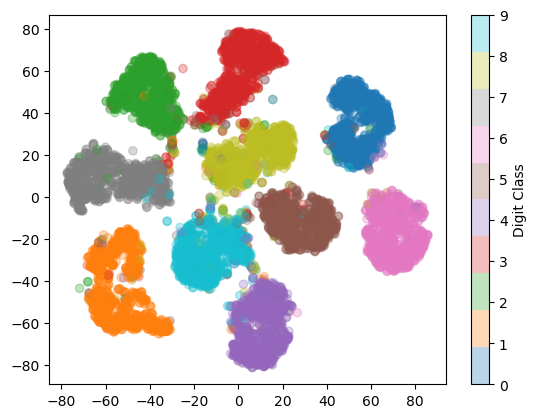

In [43]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

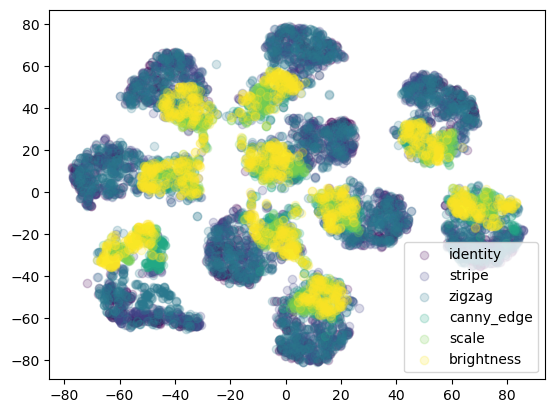

In [44]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [45]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

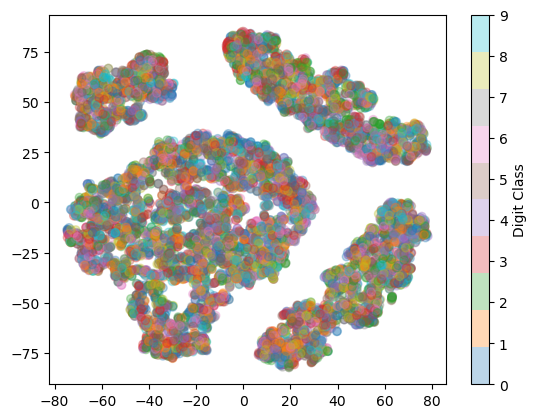

In [46]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

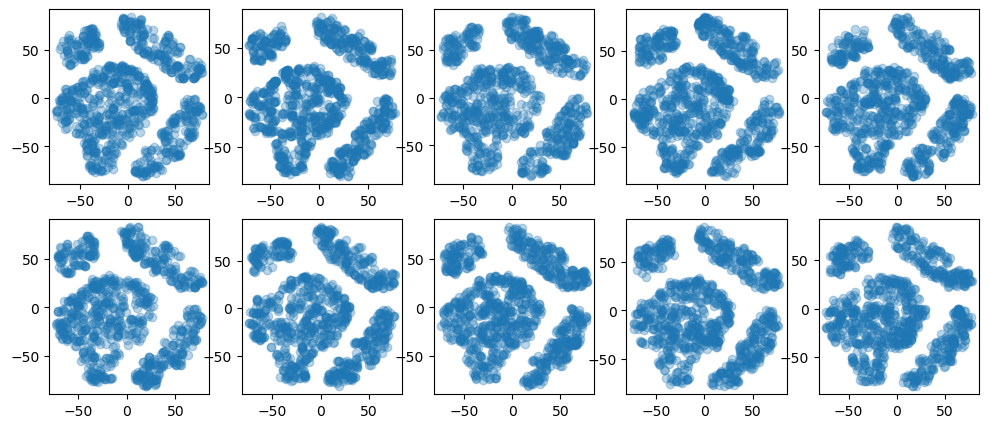

In [47]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

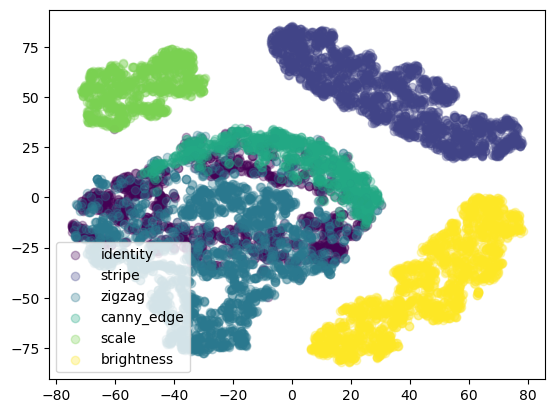

In [48]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()